In [ ]:
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML
from google.colab import files
from numpy import diff
x0_1,y0_1 = 50,25                           # Initial position for first vortex
x0_2,y0_2 = 50,75                           # Initial position for second vortex
r = 25                                      # r = 25m
Lx,Ly = 100,100                             # Space in x and y direction
A = 1                                       # A = 1s^-1
Nx = 51                                     # Grid points in x direction
Ny = 51                                     # Grid points in y direction
tol = 1e-7                                  # Tolerance = 10^-7
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)
x = np.linspace(0,Lx,Nx)
y = np.linspace(0,Ly,Ny)
x_mesh,y_mesh = np.meshgrid(x,y)

d1 = lambda x,y :np.minimum(1,(1/r)*np.sqrt((x-x0_1)**2+(y-y0_1)**2))
d2 = lambda x,y :np.minimum(1,(1/r)*np.sqrt((x-x0_2)**2+(y-y0_2)**2))
vort_function = lambda d1,d2: 0.5*A*((np.cos(d1*np.pi)+1) + (np.cos(d2*np.pi)+1))



In [ ]:
def plot_cmap(np_array,Title):
  plt.figure()
  plt.imshow(np_array,cmap = 'bwr',vmin=np.min(np_array), vmax=np.max(np_array))
  plt.colorbar()
  plt.title(Title)

In [ ]:
np.set_printoptions(threshold=np.inf)

vort = np.zeros([Nx+2,Ny+2])
vort[1:Nx+1,1:Ny+1] = vort_function(d1(x_mesh,y_mesh),d2(x_mesh,y_mesh))

vort[0,:] = vort[Nx-1,:]
vort[:,0] = vort[Ny-1,:]
vort[Nx+1,:] = vort[2,:]
vort[:,Ny+1] = vort[:,2]

sum_total = 0.0
compensation = 0.0

for value in np.nditer(vort):
  y = value - compensation
  temp = sum_total + y
  compensation = (temp - sum_total) - y
  sum_total = temp
    
num_elements = vort.size
average = sum_total/num_elements

def kahan_sum(average,vorticity):
  num_elements = vorticity.size

  while((average) > tol):
    print(average)
    vorticity = vorticity - average
    sum_total = 0.0
    compensation = 0.0

    for value in np.nditer(vorticity):
      y = value - compensation
      temp = sum_total + y
      compensation = (temp - sum_total) - y
      sum_total = temp
    

    average = sum_total/num_elements
    print(average)
    # print(vorticity)
  
  return vorticity

vort = kahan_sum(average,vort)

0.10401343100507181
-6.961126031046838e-18


In [ ]:


psi = np.zeros([Nx+2,Ny+2])                                         # Initialize psi to 0 with 2 ghost nodes on each end
residual = np.zeros([Nx+2,Ny+2])
v = np.zeros([Nx+2,Ny+2])
u = np.zeros([Nx+2,Ny+2])

residual[1:Nx+1,1:Nx+1] =  1/dx/dx *(psi[0:Nx,1:Ny+1] - 2*psi[1:Nx+1,1:Ny+1] + psi[2:Nx+2,1:Ny+1]) \
+ 1/dy/dy * (psi[1:Nx+1,0:Ny]-2*psi[1:Nx+1,1:Ny+1]+psi[1:Nx+1,2:Ny+2]) - vort[1:Nx+1,1:Ny+1] 
residual[0,:] = residual[Nx-1,:]
residual[:,0] = residual[:,Ny-1]
residual[Nx+1,:] = residual[2,:]
residual[:,Ny+1] = residual[:,2] 
# residual[1,:] = residual[Nx,:]
# residual[:,1] = residual[:,Ny]
# residual[Nx,:] = residual[1,:]
# residual[:,Ny] = residual[:,1] 

def infinite_norm(matrix):
    return np.max(np.abs(matrix))

def one_norm(matrix):
    return np.sum(np.abs(matrix))

psi_one_norm = one_norm(psi)
res_inf_norm = infinite_norm(residual)
vort_inf_norm = infinite_norm(vort)

print(psi_one_norm)
print(res_inf_norm)
print(vort_inf_norm)
e_dxdy = 2/dx/dx + 2/dy/dy

def error(psi,vort,res):
  psi_one_norm = one_norm(psi)
  res_inf_norm = infinite_norm(residual)
  vort_inf_norm = infinite_norm(vort)

  EPS = res_inf_norm /((e_dxdy)*psi_one_norm + vort_inf_norm)
  return EPS


EPS = error(psi,vort,residual)

print(EPS)

  

0.0
0.8920439196521672
0.8920439196521672
1.0


In [ ]:
# RUN A
num_iterations = 0
EPS_arr = []
while(EPS >= tol):
  for j in range(1,Ny+1):
    if(j==Ny):
      residual[:,Ny+1] = residual[:,1]
      psi[:,Ny+1] = psi[:,1]
    for i in range(1,Nx+1):
      if(i == Nx):
        #update ghost nodes at Nx+1 at current j
        residual[Nx+1,j] = residual[1,j]
        psi[Nx+1,j] = psi[1,j]

        
      residual[i,j] = 1/dx/dx * (psi[i-1,j] - 2*psi[i,j] + psi[i+1,j]) \
      + 1/dy/dy *(psi[i,j-1] - 2 * psi[i,j] + psi[i,j+1]) - vort[i,j]

      psi[i,j] = psi[i,j] + 1.90/(e_dxdy) * residual[i,j]  #Remember to subsititute 1 with optimal value of sigma
      
    #update ghost nodes at i = 0 at current j
    residual[0,j] = residual[Nx-1,j]
    psi[0,j] = psi[Nx-1,j]
  #update ghost nodes at j = 0 for all i
  residual[:,0] = residual[:,Nx-1]
  psi[:,0] = psi[:,Nx-1]

  EPS = error(psi,residual,vort)
  num_iterations += 1
  EPS_arr.append(EPS)
print(num_iterations)
print(psi.shape)

#calculate u and v by differentating psi with respect to dy and dx
# u, v = np.gradient(psi, dy, dx)
v = np.gradient(psi,dx,axis = 0)
u = np.gradient(psi,dy,axis = 1)
# Multiply d_psi_dy by -1 to get the negative of the derivative
u *= -1


# Compute the Laplacian (∇²psi) using numerical differentiation
d2_psi_dx2 = np.gradient(np.gradient(psi, axis=0), axis=0) / dx**2
d2_psi_dy2 = np.gradient(np.gradient(psi, axis=1), axis=1) / dy**2

laplacian_psi = d2_psi_dx2 + d2_psi_dy2

1865
(53, 53)


In [ ]:
# RUN A
num_iterations = 0
EPS_arr = []
while(EPS >= tol):
  for j in range(1,Ny+1):
    if(j==Ny):
      residual[Ny+1,:] = residual[1,:]
      psi[Ny+1,:] = psi[1,:]
    for i in range(1,Nx+1):
      if(i == Nx):
        #update ghost nodes at Nx+1 at current j
        residual[j,Nx+1] = residual[j,1]
        psi[j,Nx+1] = psi[j,1]

        
      residual[j,i] = 1/dx/dx * (psi[j-1,i] - 2*psi[j,i] + psi[j+1,i]) \
      + 1/dy/dy *(psi[j,i-1] - 2 * psi[j,i] + psi[j,i+1]) - vort[j,i]

      psi[j,i] = psi[j,i] + 1.9/(e_dxdy) * residual[j,i]  #Remember to subsititute 1 with optimal value of sigma
      
    #update ghost nodes at i = 0 at current j
    residual[j,0] = residual[j,Nx-1]
    psi[j,0] = psi[j,Nx-1]

  #update ghost nodes at j = 0 for all i
  residual[0,:] = residual[Nx-1,:]
  psi[0,:] = psi[Nx-1,:]

  EPS = error(psi,residual,vort)
  num_iterations += 1
  EPS_arr.append(EPS)
print(num_iterations)
print(psi.shape)

#calculate u and v by differentating psi with respect to dy and dx
# u, v = np.gradient(psi, dy, dx)
v = np.gradient(psi,dx,axis = 0)
u = np.gradient(psi,dy,axis = 1)
# Multiply d_psi_dy by -1 to get the negative of the derivative
u *= -1


# Compute the Laplacian (∇²psi) using numerical differentiation
d2_psi_dx2 = np.gradient(np.gradient(psi, axis=0), axis=0) / dx**2
d2_psi_dy2 = np.gradient(np.gradient(psi, axis=1), axis=1) / dy**2

laplacian_psi = d2_psi_dx2 + d2_psi_dy2

1865
(53, 53)


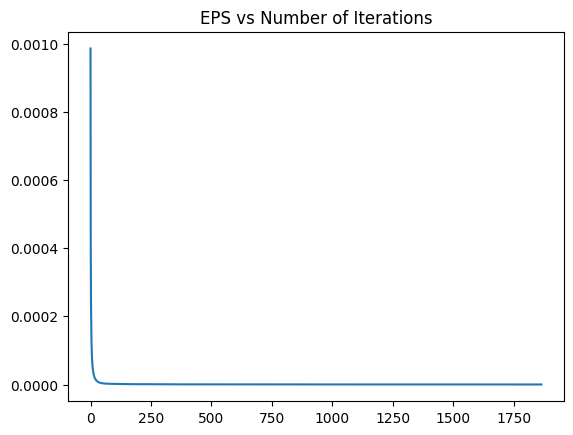

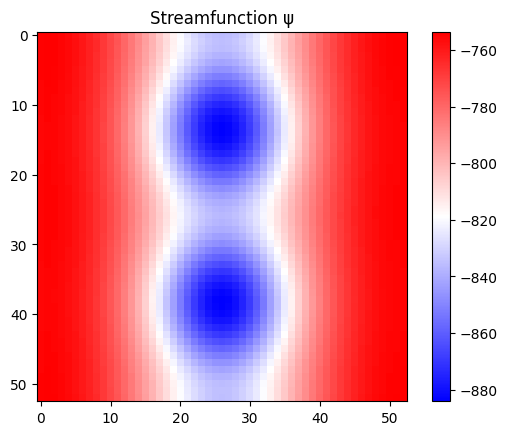

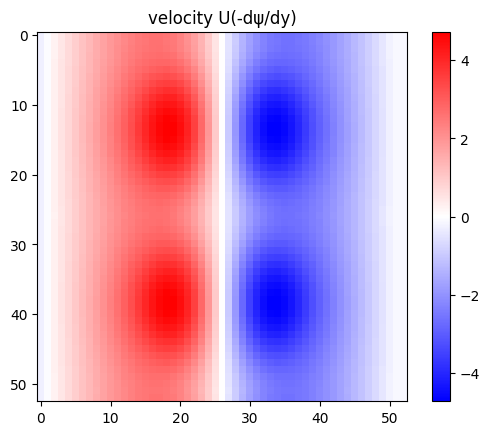

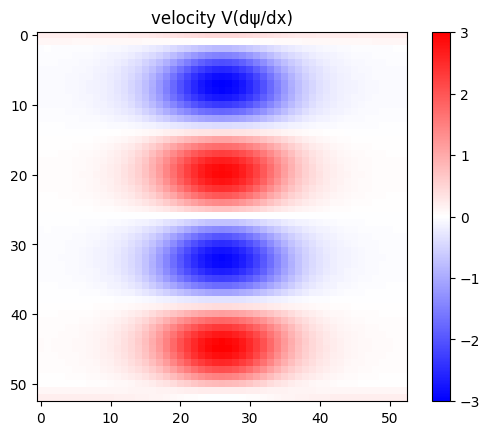

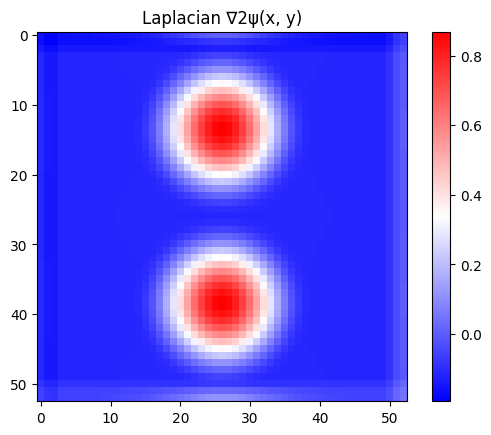

In [ ]:

iter_arr = np.linspace(0,num_iterations,num_iterations)
plt.figure()
plt.plot(iter_arr,EPS_arr)
plt.title('EPS vs Number of Iterations')
plt.show()

plot_cmap(psi,'Streamfunction ψ')
plot_cmap(u,'velocity U(-dψ/dy)')
plot_cmap(v,'velocity V(dψ/dx)')
plot_cmap(laplacian_psi,'Laplacian ∇2ψ(x, y)')

In [ ]:
psi = np.zeros([Nx+2,Ny+2])                                         # Initialize psi to 0 with 2 ghost nodes on each end
residual = np.zeros([Nx+2,Ny+2])
v = np.zeros([Nx+2,Ny+2])
u = np.zeros([Nx+2,Ny+2])

residual[1:Nx+1,1:Ny+1] =  1/dx/dx *(psi[0:Nx,1:Ny+1] - 2*psi[1:Nx+1,1:Ny+1] + psi[2:Nx+2,1:Ny+1]) \
+ 1/dy/dy * (psi[1:Nx+1,0:Ny]-2*psi[1:Nx+1,1:Ny+1]+psi[1:Nx+1,2:Ny+2]) - vort[1:Nx+1,1:Ny+1] 
# residual[0,:] = residual[Nx-1,:]
# residual[Nx+1,:] = residual[2,:]
# residual[:,0] = 0
# residual[:,Ny+1] = 0
# residual[:,1] = 0
# residual[:,Ny] = 0

residual[:,0] = residual[:,Nx-1]
residual[:,Nx+1] = residual[:,2]
residual[1,:] = 0
residual[Ny,:] = 0

psi_one_norm = one_norm(psi)
res_inf_norm = infinite_norm(residual)
vort_inf_norm = infinite_norm(vort)

EPS = error(psi,vort,residual)
print(EPS)



1.0


In [ ]:
# RUN B
num_iterations = 0
EPS = 1.0
EPS_arr = []
while(EPS >= tol):
  for j in range(2,Ny):
    for i in range(1,Nx+1):
      if(i == Nx):
        #update ghost nodes at Nx+1 at current j
        residual[j,Nx+1] = residual[j,1]
        psi[j,Nx+1] = psi[j,1]

        
      residual[j,i] = 1/dx/dx * (psi[j-1,i] - 2*psi[j,i] + psi[j+1,i]) \
      + 1/dy/dy *(psi[j,i-1] - 2 * psi[j,i] + psi[j,i+1]) - vort[j,i]

      psi[j,i] = psi[j,i] + 1.9/(e_dxdy) * residual[j,i]  #Remember to subsititute 1 with optimal value of sigma
      
    #update ghost nodes at i = 0 at current j
    residual[j,0] = residual[j,Nx-1]
    psi[j,0] = psi[j,Nx-1]

  EPS = error(psi,residual,vort)
  num_iterations += 1
  EPS_arr.append(EPS)
psi[Ny,:] = 0
psi[1,:] = 0
psi[0,:] = 0
psi[Ny+1,:] = 0
print(num_iterations)
print(psi.shape)

#calculate u and v by differentating psi with respect to dy and dx
v = np.gradient(psi,dx,axis = 0)
u = np.gradient(psi,dy,axis = 1)

# Multiply d_psi_dy by -1 to get the negative of the derivative
u *= -1

# Compute the Laplacian (∇²psi) using numerical differentiation
d2_psi_dx2 = np.gradient(np.gradient(psi, axis=0), axis=0) / dx**2
d2_psi_dy2 = np.gradient(np.gradient(psi, axis=1), axis=1) / dy**2

laplacian_psi = d2_psi_dx2 + d2_psi_dy2

113
(53, 53)


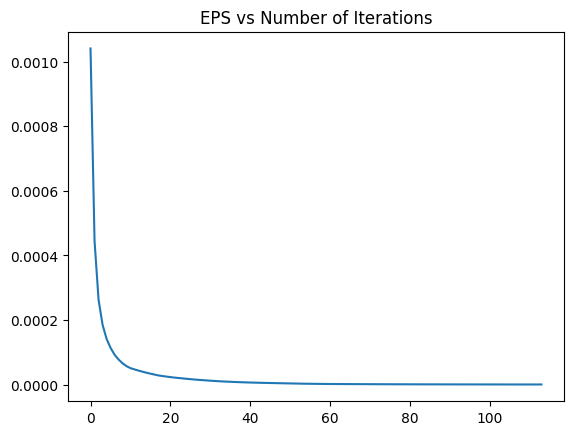

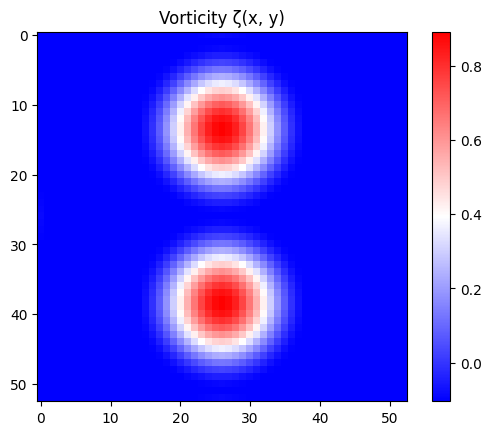

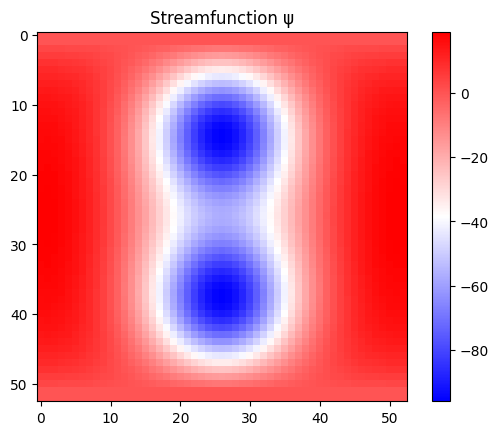

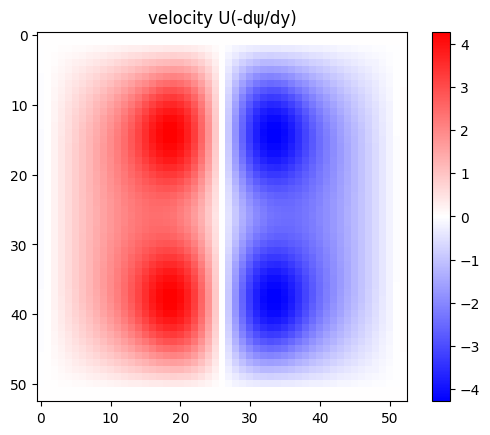

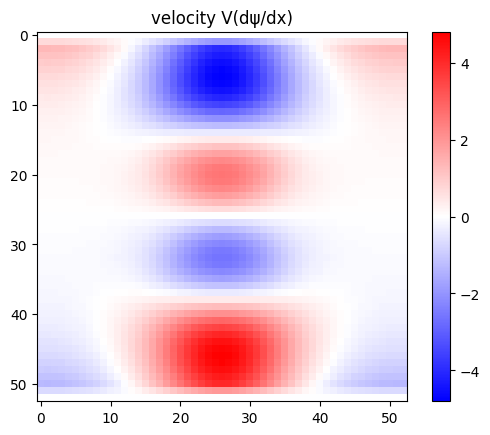

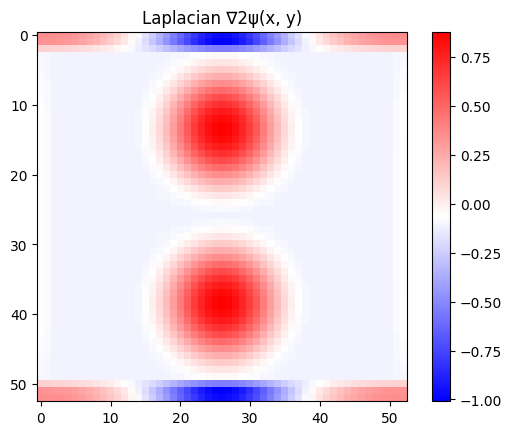

In [ ]:
#plot EPS over number of iterations

iter_arr = np.linspace(0,num_iterations,num_iterations)
plt.figure()
plt.plot(iter_arr,EPS_arr)
plt.title('EPS vs Number of Iterations')
plt.show()
plot_cmap(vort,"Vorticity ζ(x, y)")
plot_cmap(psi,'Streamfunction ψ')
plot_cmap(u,'velocity U(-dψ/dy)')
plot_cmap(v,'velocity V(dψ/dx)')
plot_cmap(laplacian_psi,'Laplacian ∇2ψ(x, y)')